In [23]:
import scanpy as sc
import scvi
import anndata as ad
import numpy as np
import os
import warnings
import pertpy as pt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.chdir("/data/TAK_981/")
import pandas as pd
sc._settings.ScanpyConfig.n_jobs = 5

In [14]:
adata = sc.read_h5ad("h5ad/batch_corrected.h5ad")
adata = adata[~(adata.obs.annot.isin(["RBC", "Acinar", "B Cells"]))]

In [15]:
sccoda_model = pt.tl.Sccoda()

In [16]:
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="annot",
    sample_identifier="sample_id",
    covariate_obs=["condition"],
)

In [17]:
sccoda_data

MuData object with n_obs × n_vars = 134126 × 8007
  2 modalities
    rna:	134118 x 8000
      obs:	'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'vaeda_scores', 'vaeda_calls', 'outlier', 'mt_outlier', 'sample_id', 'condition', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'annot', 'scCODA_sample_id'
      var:	'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'sample_id_colors', 'umap'
      obsm:	'X_scVI', 'X_scVI_MDE', 'X_umap', '_scvi_extra_continuous_covs', 'cellbender_embedding', 'vaeda_embedding'
      layers:	'cellbender', 'counts', 'raw'
      obsp:	'connectivities', 'distances'
    coda:	8 x 7
      obs:	'condition', 'sample_id'
      var:	'n_cells'

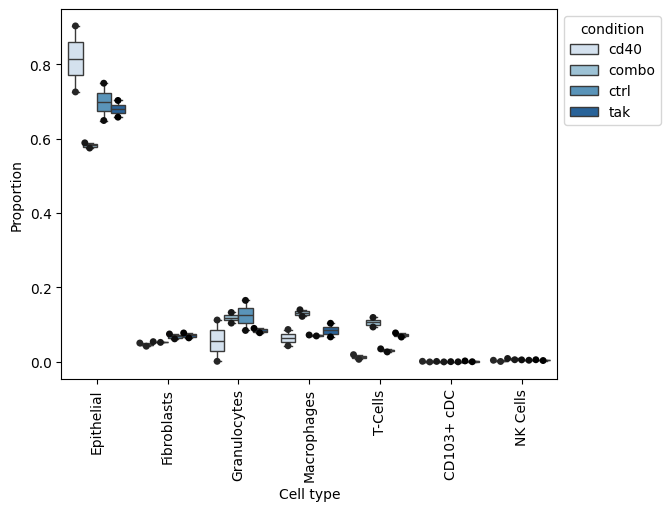

In [18]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda", feature_name="condition", add_dots=True)
plt.show()

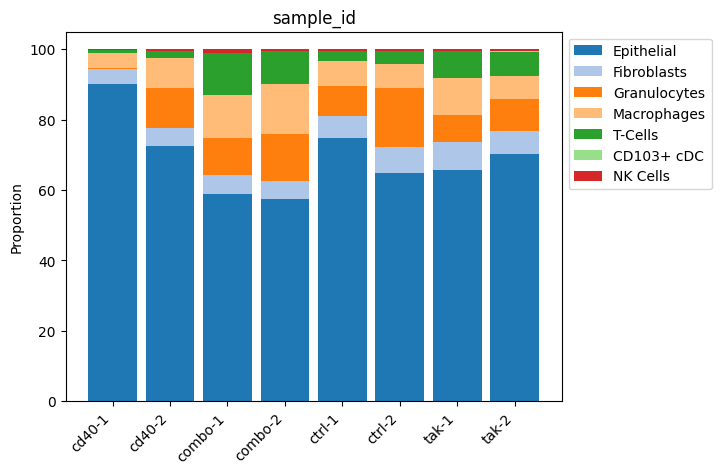

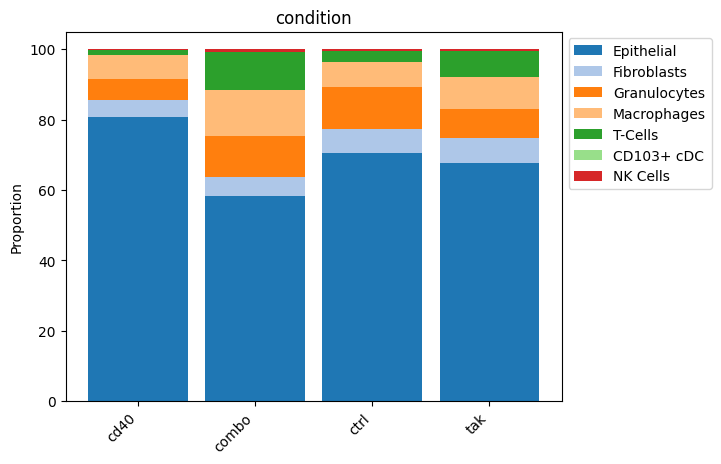

In [19]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda",
                                  feature_name="sample_id")
plt.show()

sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda",
                                  feature_name="condition")
plt.show()

<Axes: xlabel='Presence', ylabel='Total dispersion'>

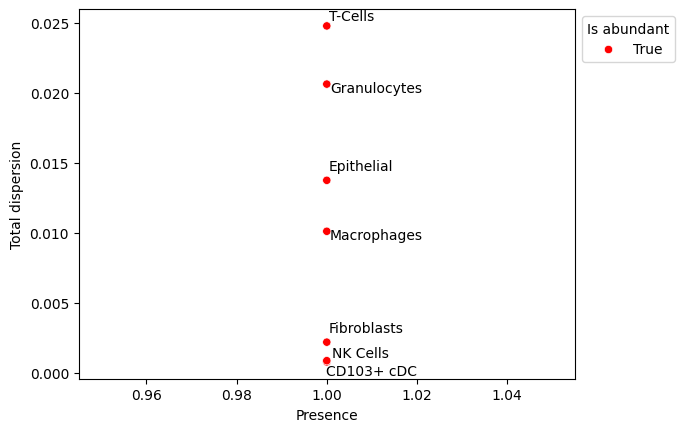

In [21]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data,
                                                modality_key="coda",
                                                abundant_threshold=0.95)

In [22]:
sccoda_data.mod["coda"].obs.condition

scCODA_sample_id
cd40-1      cd40
cd40-2      cd40
combo-1    combo
combo-2    combo
ctrl-1      ctrl
ctrl-2      ctrl
tak-1        tak
tak-2        tak
Name: condition, dtype: category
Categories (4, object): ['cd40', 'combo', 'ctrl', 'tak']

In [28]:
comp = ["ctrlvcd40", "ctrlvtak", "ctrlvcombo", "takvcombo",
        "takvcd40", "cd40vcombo"]
res = []
fdr = [0.1, 0.15, 0.2]
for reference in ["Epithelial", "Fibroblasts"]:
    for n in comp:
        conds = n.split('v')
        dat = sccoda_model.load(
            adata[adata.obs["condition"].isin(conds)],
            type="cell_level",
            generate_sample_level=True,
            cell_type_identifier="annot",
            sample_identifier="sample_id",
            covariate_obs=["condition"],
            )
        dat = sccoda_model.prepare(dat,
                                   modality_key="coda",
                                   formula=f"C(condition, Treatment('{conds[0]}'))",
                                   reference_cell_type=reference)
        sccoda_model.run_nuts(dat, modality_key="coda")
        df = sccoda_model.get_effect_df(dat, modality_key="coda")
        df['fdr']=0.05
        df_list = []
        for x in fdr:
            sccoda_model.set_fdr(dat, modality_key="coda", est_fdr=x)
            effects = sccoda_model.get_effect_df(dat, modality_key="coda")
            effects['fdr'] = x
            df = pd.concat([df, effects])
        df["Comparison"] = n
        df_list.append(df)
    final_df = pd.concat(df_list)
    final_df["Credible Effect"] = np.where(final_df['Final Parameter'] != 0, True, 
                                           False)
    final_df = final_df.reset_index()
    final_df.drop("Covariate", axis=1, inplace=True)
    final_df = final_df.loc[:, ["Cell Type", "Comparison", "Credible Effect",
                                "fdr", "log2-fold change",
                                "Final Parameter", "HDI 3%",
                                "HDI 97%", "SD",
                                "Inclusion probability", "Expected Sample"]]
    final_df.to_csv(f"csv/da/{reference}_model_outputs.csv", index=False)

sample: 100%|██████████| 11000/11000 [00:13<00:00, 840.37it/s, 127 steps of size 2.47e-02. acc. prob=0.82] 


In [30]:
sccoda_data.mod["coda"].X

array([[14629,   685,    27,   704,   113,    28,    21],
       [13403,   939,  2081,  1610,   362,     1,    83],
       [11712,  1084,  2076,  2436,  2378,    28,   185],
       [ 9296,   850,  2150,  2268,  1518,     2,    96],
       [11732,   972,  1326,  1134,   421,    12,    72],
       [ 7867,   911,  2006,   847,   427,     4,    68],
       [14057,  1664,  1676,  2220,  1667,    12,    81],
       [ 9958,   916,  1279,   953,   948,    39,    84]])

In [34]:
sccoda_data.mod["coda"].var

,n_cells
annot,
Epithelial,92654
Fibroblasts,8021
Granulocytes,12621
Macrophages,12172
T-Cells,7834
CD103+ cDC,126
NK Cells,690


In [33]:
sccoda_data.mod["coda"].obs

,condition,sample_id
scCODA_sample_id,,
cd40-1,cd40,cd40-1
cd40-2,cd40,cd40-2
combo-1,combo,combo-1
combo-2,combo,combo-2
ctrl-1,ctrl,ctrl-1
ctrl-2,ctrl,ctrl-2
tak-1,tak,tak-1
tak-2,tak,tak-2


In [52]:
prop_df = pd.DataFrame(sccoda_data.mod["coda"].X, 
                       index=sccoda_data.mod["coda"].obs.index,
                       columns=sccoda_data.mod["coda"].var.index)
prop_df.to_csv("csv/da/raw_numbers.csv")
totals = prop_df.sum(axis=1)
sample_props = prop_df.div(totals, axis=0)
sample_props.to_csv("csv/da/sample_proportions.csv")
grouped = prop_df.groupby(by=sccoda_data.mod["coda"].obs["condition"]).sum()
totals_cond = grouped.sum(axis=1)
cond_props = grouped.div(totals_cond, axis=0)
cond_props.to_csv("csv/da/condition_proportions.csv")
